# How to simulate multiple virus strains

In this tutorial, we are going to simulate the spread of Covid-19 with two virus strains.

In [1]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sid
from sid.config import INDEX_NAMES

warnings.filterwarnings("ignore")

## Preparation

For the simulation we need to prepare several objects which are identical to the ones from the general tutorial on the [simulation](how_to_simulate.ipynb).

In [2]:
available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=10_000)
regions = np.random.choice(["North", "South"], size=10_000)

initial_states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
initial_states.head(5)

,age_group,region
0,80-100,North
1,30-39,South
2,80-100,North
3,50-59,South
4,0-9,South


In [3]:
def meet_distant(states, params, seed):
    possible_nr_contacts = np.arange(10)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, seed):
    possible_nr_contacts = np.arange(5)
    contacts = np.random.choice(possible_nr_contacts, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by, "is_recurrent": False},
    "close": {"model": meet_close, "assort_by": assort_by, "is_recurrent": False},
}

In [4]:
epidemiological_parameters = pd.read_csv("infection_probs.csv", index_col=INDEX_NAMES)
epidemiological_parameters

value  note  source
category       subcategory name                          
infection_prob close       close       0.05   NaN     NaN
               distant     distant     0.03   NaN     NaN
               household   household   0.20   NaN     NaN

In [5]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=INDEX_NAMES)
assort_probs

value  note  source
category             subcategory name                          
assortative_matching close       age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN
                     distant     age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN

In [6]:
disease_params = sid.load_epidemiological_parameters()
disease_params.head(6).round(2)

value
category            subcategory        name                     
health_system       icu_limit_relative icu_limit_relative  50.00
cd_infectious_true  all                1                    0.39
                                       2                    0.35
                                       3                    0.22
                                       5                    0.04
cd_infectious_false all                3                    0.10

In [7]:
immunity_params = pd.read_csv("immunity_params.csv", index_col=INDEX_NAMES)
immunity_params

value  note  \
category subcategory     name                                               
immunity immunity_level  from_infection                      0.9900   NaN   
                         from_vaccination                    0.8000   NaN   
         immunity_waning time_to_reach_maximum_infection     7.0000   NaN   
                         time_to_reach_maximum_vaccination  28.0000   NaN   
                         slope_after_maximum_infection      -0.0001   NaN   
                         slope_after_maximum_vaccination    -0.0002   NaN   

                                                            source  
category subcategory     name                                       
immunity immunity_level  from_infection                        NaN  
                         from_vaccination                      NaN  
         immunity_waning time_to_reach_maximum_infection       NaN  
                         time_to_reach_maximum_vaccination     NaN  
                         slope_after_maximum_infection         NaN  
                         slope_after_maximum_vaccination       NaN

In [8]:
params = pd.concat(
    [disease_params, epidemiological_parameters, assort_probs, immunity_params]
)

## Additional objects to simulate multiple virus strains

To implement multiple virus strains, we have to make the following extensions to the model.

1. Add a multiplier for the contagiousness of each virus to the parameters.
2. Add a multiplier for the immunity resistance factor for each virus to the parameters.
3. Prepare a DataFrame for the initial conditions.

> Here we set the immunity resistance factor to 1, which (de facto) removes its influence on the 
> simulation. A detailed discussion on how to use this parameter is given in the tutorial on
> [immunity](how_to_model_immunity.ipynb).

In [9]:
for virus, cf in [("base", 1), ("b117", 1.3)]:
    params.loc[("virus_strain", virus, "contagiousness_factor"), "value"] = cf
    params.loc[("virus_strain", virus, "immunity_resistance_factor"), "value"] = 1.0

For the initial conditions, we assume a two-day burn-in period. On the first day, 50 people are infected with the base virus, on the second day one halve of 50 people has the old and the other halve the new variant.

Each column in the DataFrame is a categorical. Infected individuals have a code for the variant, all others have NaNs.

In [10]:
infected_first_day = set(np.random.choice(10_000, size=50, replace=False))
first_day = pd.Series([pd.NA] * 10_000)
first_day.iloc[list(infected_first_day)] = "base"

In [11]:
infected_second_day_old_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day), size=25, replace=False
    )
)
infected_second_day_new_variant = set(
    np.random.choice(
        list(set(range(10_000)) - infected_first_day - infected_second_day_old_variant),
        size=25,
        replace=False,
    )
)

second_day = pd.Series([pd.NA] * 10_000)
second_day.iloc[list(infected_second_day_old_variant)] = "base"
second_day.iloc[list(infected_second_day_new_variant)] = "b117"

In [12]:
initial_infections = pd.DataFrame(
    {
        pd.Timestamp("2020-02-25"): pd.Categorical(
            first_day, categories=["base", "b117"]
        ),
        pd.Timestamp("2020-02-26"): pd.Categorical(
            second_day, categories=["base", "b117"]
        ),
    }
)

In [13]:
initial_conditions = {"initial_infections": initial_infections, "initial_immunity": 50}

## Run the simulation

We are going to simulate this population for 200 periods.

In [14]:
simulate = sid.get_simulate_func(
    initial_states=initial_states,
    contact_models=contact_models,
    params=params,
    initial_conditions=initial_conditions,
    duration={"start": "2020-02-27", "periods": 365},
    virus_strains=["base", "b117"],
    seed=0,
)
result = simulate(params=params)

Start the simulation...
2021-02-25: 100%|██████████| 365/365 [00:36<00:00, 10.07it/s]


In [15]:
result["time_series"].head()

,new_known_case,age_group,ever_infected,date,n_has_infected,cd_infectious_false,knows_immune,ever_vaccinated,symptomatic,needs_icu,infectious,is_tested_positive_by_rapid_test,newly_deceased,region,newly_vaccinated,knows_infectious,dead,immunity,newly_infected,virus_strain
0,False,80-100,False,2020-02-27,0,-10002,False,False,False,False,False,False,False,North,False,False,False,0.0,False,NaN
1,False,30-39,False,2020-02-27,0,-10002,False,False,False,False,False,False,False,South,False,False,False,0.0,False,NaN
2,False,80-100,False,2020-02-27,0,-10002,False,False,False,False,False,False,False,North,False,False,False,0.0,False,NaN
3,False,50-59,False,2020-02-27,0,-10002,False,False,False,False,False,False,False,South,False,False,False,0.0,False,NaN
4,False,0-9,False,2020-02-27,0,-10002,False,False,False,False,False,False,False,South,False,False,False,0.0,False,NaN


In [16]:
result["last_states"].head()

,age_group,region,ever_infected,infectious,symptomatic,needs_icu,dead,pending_test,received_test_result,knows_immune,...,cd_needs_icu_true_draws,cd_received_test_result_true_draws,cd_symptoms_false_draws,cd_symptoms_true_draws,group_codes_close,group_codes_distant,date,period,n_contacts_close,n_contacts_distant
0,80-100,North,True,False,False,False,False,False,False,False,...,-1,2,27,-1,16,16,2021-02-25,786,2,2
1,30-39,South,True,False,False,False,False,False,False,False,...,-1,4,18,-1,7,7,2021-02-25,786,2,9
2,80-100,North,True,False,False,False,False,False,False,False,...,-1,2,18,1,16,16,2021-02-25,786,0,9
3,50-59,South,True,False,True,False,False,False,False,False,...,-1,1,27,1,11,11,2021-02-25,786,3,8
4,0-9,South,True,True,False,False,False,False,False,False,...,-1,1,27,-1,1,1,2021-02-25,786,4,8


The return of `simulate` is a dictionary with containing the time series data and the last states as a [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html). This allows to load the data lazily.

The ``last_states`` can be used to resume the simulation. We will inspect the ``time_series`` data. If data data fits your working memory, do the following to convert it to a pandas DataFrame.

In [17]:
df = result["time_series"].compute()

Let us take a look at various statistics of the sample.

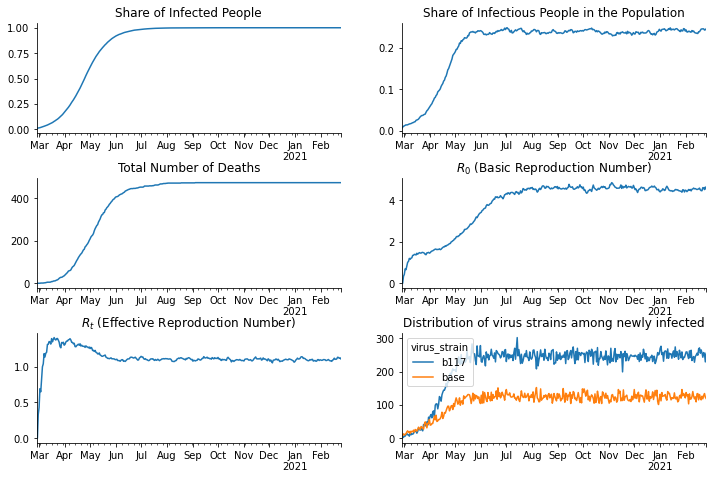

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
fig.subplots_adjust(bottom=0.15, wspace=0.2, hspace=0.4)

axs = axs.flatten()

df.resample("D", on="date")["ever_infected"].mean().plot(ax=axs[0])
df.resample("D", on="date")["infectious"].mean().plot(ax=axs[1])
df.resample("D", on="date")["dead"].sum().plot(ax=axs[2])

r_zero = sid.statistics.calculate_r_zero(df, window_length=7)
r_zero.plot(ax=axs[3])

r_effective = sid.statistics.calculate_r_effective(df, window_length=7)
r_effective.plot(ax=axs[4])

df.query("newly_infected").groupby([pd.Grouper(key="date", freq="D"), "virus_strain"])[
    "newly_infected"
].count().unstack().plot(ax=axs[5])

for ax in axs:
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

axs[0].set_title("Share of Infected People")
axs[1].set_title("Share of Infectious People in the Population")
axs[2].set_title("Total Number of Deaths")
axs[3].set_title("$R_0$ (Basic Reproduction Number)")
axs[4].set_title("$R_t$ (Effective Reproduction Number)")
axs[5].set_title("Distribution of virus strains among newly infected")

plt.show()